In [1]:
library(ArchR)
library(BSgenome.Hsapiens.UCSC.hg38)
set.seed(1)
threads <- parallel::detectCores() - 1
addArchRThreads(threads = threads)
addArchRLocking(FALSE)
addArchRGenome("hg38")


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
collab_dir <- "../../../data/data_raw/collaborators/processed"
pub_dir   <- "../../../data/data_raw/granja/hg38"

In [3]:
pub_frags    <- list.files(pub_dir,
                           pattern = "\\.fragments\\.tsv\\.gz$",
                           full.names = TRUE)
pub_frags <- pub_frags[!grepl("lt120", pub_frags)]

pub_raw <- sub("_hg38\\.fragments\\.tsv\\.gz$", "", basename(pub_frags))
pub_suffixes <- sub(".*(_D\\d+T\\d+)$", "\\1", pub_raw)
pub_names <- paste0("granja", pub_suffixes)

In [4]:
all_frags  <- c(
  file.path(collab_dir, "collab_donor0_fragments.tsv.gz"),
  file.path(collab_dir, "collab_donor1_fragments.tsv.gz"),
  pub_frags
)
all_names  <- c("collab_0", "collab_1", pub_names)

In [5]:
arrow_files_unfiltered <- createArrowFiles(
  inputFiles      = all_frags,
  sampleNames     = all_names,
  minFrags        = 0,
  minTSS          = 0,
  addTileMat      = TRUE,
  addGeneScoreMat = TRUE,
  force           = TRUE
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

ArchR logging to : ArchRLogs/ArchR-createArrows-dc4978ba961b-Date-2025-11-28_Time-10-21-07.727614.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

Disabling H5 File Locking. If this is not desired check `addArchRLocking`.

subThreading Enabled since ArchRLocking is FALSE see `addArchRLocking`

2025-11-28 10:21:08.151104 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-createArrows-dc4978ba961b-Date-2025-11-28_Time-10-21-07.727614.log



In [6]:
proj_unfiltered <- ArchRProject(
  ArrowFiles      = arrow_files_unfiltered,
  outputDirectory = "ArchR_Collab_vs_Pub_Unfiltered",
  copyArrows      = FALSE
)

# Add Tissue metadata to unfiltered project
tissue_lookup_unfilt <- setNames(
  ifelse(grepl("^collab_", all_names), "MobilizedBlood", "BoneMarrow"),
  all_names
)
proj_unfiltered <- addCellColData(
  proj_unfiltered,
  data      = tissue_lookup_unfilt[proj_unfiltered$Sample],
  cells     = proj_unfiltered$cellNames,
  name      = "Tissue",
  force     = TRUE
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,-

Some values are not finite! Excluding these points!

Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”
Plotting Ggplot!



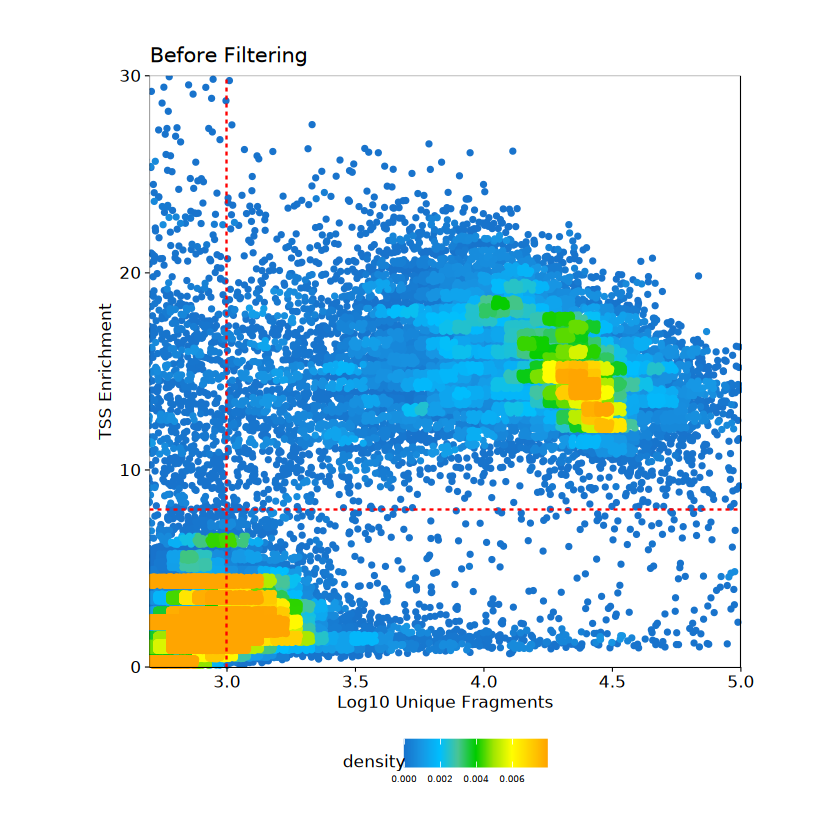

In [7]:
# Get cell counts before filtering
cells_before <- table(proj_unfiltered$Sample)
tissue_before <- table(proj_unfiltered$Tissue)

# TSS vs Frags plot BEFORE filtering - include Sample column
df_unfilt <- getCellColData(proj_unfiltered, select = c("Sample", "log10(nFrags)", "TSSEnrichment"))

p_unfilt <- ggPoint(
    x = df_unfilt[,2],
    y = df_unfilt[,3],
    colorDensity = TRUE,
    continuousSet = "sambaNight",
    xlabel = "Log10 Unique Fragments",
    ylabel = "TSS Enrichment",
    xlim = c(log10(500), 5),
    ylim = c(0, 30)
) + geom_hline(yintercept = 8, lty = "dashed", color = "red") + 
    geom_vline(xintercept = log10(1000), lty = "dashed", color = "red") +
    ggtitle("Before Filtering")

p_unfilt
plotPDF(p_unfilt, name = "TSS-vs-Frags-BEFORE-Filtering.pdf", 
        ArchRProj = proj_unfiltered, addDOC = FALSE)

In [8]:
# Quick sanity checks
table(proj_unfiltered$Sample)
length(proj_unfiltered$cellNames)

# Compute median and mean per sample - now Sample is in df_unfilt
tss_median <- aggregate(TSSEnrichment ~ Sample, data = df_unfilt, FUN = median)
tss_mean   <- aggregate(TSSEnrichment ~ Sample, data = df_unfilt, FUN = mean)
tss_stats <- merge(tss_median, tss_mean, by="Sample",
                   suffixes = c("_median","_mean"))
print("TSS Stats BEFORE filtering:")
print(tss_stats)


   collab_0    collab_1 granja_D7T1 granja_D8T1 granja_D9T1 
       3920        3540      360061      315711      285179 

[1] 968411

[1] "TSS Stats BEFORE filtering:"
       Sample TSSEnrichment_median TSSEnrichment_mean
1    collab_0               14.012         14.3657367
2    collab_1               13.635         14.0271684
3 granja_D7T1                0.000          0.5048709
4 granja_D8T1                0.000          0.3810034
5 granja_D9T1                0.000          0.4505600


In [9]:
minTSS   <- 8
minFrags <- 1000
goodCells <- proj_unfiltered$cellNames[
  proj_unfiltered$TSSEnrichment >= minTSS &
  proj_unfiltered$nFrags        >= minFrags
]

In [10]:
proj <- subsetArchRProject(
  proj_unfiltered,
  cells          = goodCells,
  dropCells      = TRUE,
  outputDirectory = "ArchR_Collab_vs_Pub_QCFiltered",
  force          = TRUE
)

Copying ArchRProject to new outputDirectory : /work/project/ladcol_013/bt-atac/notebooks/1_processing/test/ArchR_Collab_vs_Pub_QCFiltered

Copying Arrow Files...

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 1): Plots

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__              

In [18]:
df_filt <- getCellColData(proj, select = c("Sample", "log10(nFrags)", "TSSEnrichment"))

tss_median_filt <- aggregate(TSSEnrichment ~ Sample, data = df_filt, FUN = median)
tss_mean_filt   <- aggregate(TSSEnrichment ~ Sample, data = df_filt, FUN = mean)
tss_stats_filt <- merge(tss_median_filt, tss_mean_filt, by="Sample",
                   suffixes = c("_median","_mean"))

cat("\n=== TSS Stats AFTER filtering ===\n")
print(tss_stats_filt)

# Check cell retention by sample
cat("\n=== Cell counts before/after ===\n")
cells_after <- table(proj$Sample)
retention_df <- data.frame(
  Sample = names(cells_before),
  Before = as.numeric(cells_before),
  After = as.numeric(cells_after[names(cells_before)]),
  Retained_Pct = round(100 * as.numeric(cells_after[names(cells_before)]) / as.numeric(cells_before), 1)
)
print(retention_df)


=== TSS Stats AFTER filtering ===
       Sample TSSEnrichment_median TSSEnrichment_mean
1    collab_0              14.0130           14.36277
2    collab_1              13.6300           14.00519
3 granja_D7T1              15.1260           15.14369
4 granja_D8T1              15.5400           15.56138
5 granja_D9T1              16.3405           16.42714

=== Cell counts before/after ===
       Sample Before After Retained_Pct
1    collab_0   3920  3835         97.8
2    collab_1   3540  3478         98.2
3 granja_D7T1 360061  3313          0.9
4 granja_D8T1 315711  3621          1.1
5 granja_D9T1 285179  4034          1.4


In [11]:
# We need one plot here with number of cells per sample and number of cells per tissue (now using the Tissue Column) AFTER filtering for minFrags and minTSS
# Also, we need a second plot with Frags/TSS scores per sample and per Tissue

In [19]:
proj <- addDoubletScores(
  proj,
  dimsToUse = 1:20,
  force = TRUE
)
proj <- filterDoublets(proj)

proj <- subsetArchRProject(
  proj,
  cells          = proj$cellNames,
  dropCells      = TRUE,
  outputDirectory = "ArchR_Collab_vs_Pub_QC1",
  force          = TRUE
)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-dc494626422d-Date-2025-11-28_Time-10-52-40.786618.log
If there is an issue, please report to github with logFile!

2025-11-28 10:52:41.400021 : Batch Execution w/ safelapply!, 0 mins elapsed.

2025-11-28 10:52:41.412019 : collab_0 (1 of 5) :  Computing Doublet Statistics, 0 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
collab_0 (1 of 5) : UMAP Projection R^2 = 0.97498

collab_0 (1 of 5) : UMAP Projection R^2 = 0.97498

2025-11-28 10:55:31.068295 : collab_1 (2 of 5) :  Computing Doublet Statistics, 2.828 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Filtering 1 dims correlated > 0.75 to log10(depth + 1)

collab_1 (2 of 5) : UMAP Projection R^2 = 0.98765

collab_1 (2 of 5) : UMAP Projection R^2 = 0.98765

2025-11-28 10:58:02.88312 : granja_D8T1 (3 of 5) : 

[1] "Cell counts comparison:"
                 Sample Before After         Tissue Filtered Percent_Retained
collab_0       collab_0   3920  3688 MobilizedBlood      232             94.1
collab_1       collab_1   3540  3358 MobilizedBlood      182             94.9
granja_D7T1 granja_D7T1 360061  3204     BoneMarrow   356857              0.9
granja_D8T1 granja_D8T1 315711  3490     BoneMarrow   312221              1.1
granja_D9T1 granja_D9T1 285179  3872     BoneMarrow   281307              1.4



Attache Paket: ‘reshape2’


Die folgenden Objekte sind maskiert von ‘package:data.table’:

    dcast, melt


Plotting Ggplot!



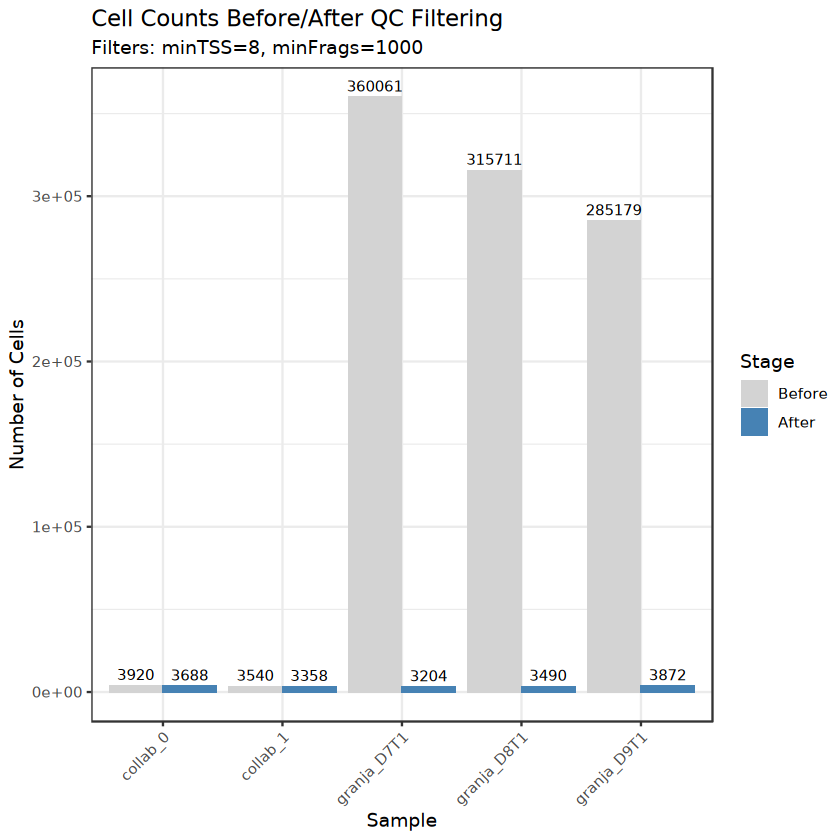

Plotting Ggplot!



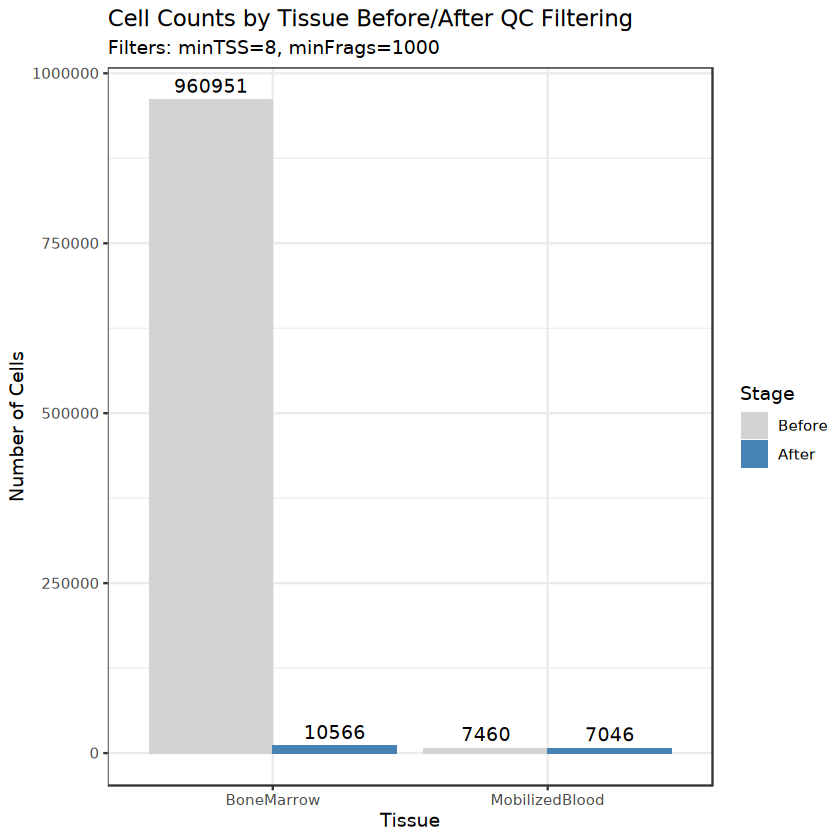

Plotting Ggplot!



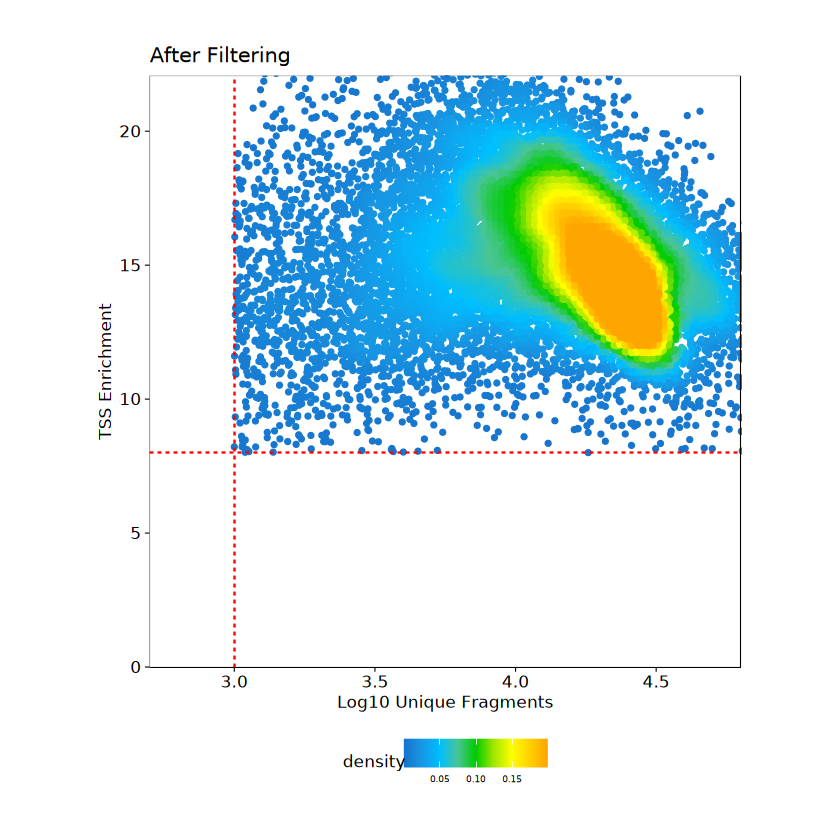

In [20]:
# ===== AFTER FILTERING: Cell counts and QC plots =====
# Get cell counts after filtering
cells_after <- table(proj$Sample)
tissue_after <- table(proj$Tissue)

# Create comparison data frames
cells_comparison <- data.frame(
  Sample = names(cells_before),
  Before = as.numeric(cells_before),
  After = as.numeric(cells_after[names(cells_before)]),
  Tissue = tissue_lookup_unfilt[names(cells_before)]
)
cells_comparison$Filtered <- cells_comparison$Before - cells_comparison$After
cells_comparison$Percent_Retained <- round(100 * cells_comparison$After / cells_comparison$Before, 1)

print("Cell counts comparison:")
print(cells_comparison)

# Reshape for plotting
library(reshape2)
cells_long <- melt(cells_comparison[, c("Sample", "Before", "After", "Tissue")], 
                   id.vars = c("Sample", "Tissue"),
                   variable.name = "Stage", 
                   value.name = "Cells")

# Plot 1: Cells per sample (before/after)
p_cells_sample <- ggplot(cells_long, aes(x = Sample, y = Cells, fill = Stage)) +
  geom_bar(stat = "identity", position = "dodge") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual(values = c("Before" = "lightgray", "After" = "steelblue")) +
  labs(title = "Cell Counts Before/After QC Filtering",
       subtitle = paste0("Filters: minTSS=", minTSS, ", minFrags=", minFrags),
       y = "Number of Cells") +
  geom_text(aes(label = Cells), position = position_dodge(width = 0.9), 
            vjust = -0.5, size = 3)

print(p_cells_sample)
plotPDF(p_cells_sample, name = "Cell-Counts-Sample-Comparison.pdf", 
        ArchRProj = proj, addDOC = FALSE, width = 10, height = 6)

# Aggregate by tissue
tissue_long <- aggregate(Cells ~ Tissue + Stage, data = cells_long, FUN = sum)

# Plot 2: Cells per tissue (before/after)
p_cells_tissue <- ggplot(tissue_long, aes(x = Tissue, y = Cells, fill = Stage)) +
  geom_bar(stat = "identity", position = "dodge") +
  theme_bw() +
  scale_fill_manual(values = c("Before" = "lightgray", "After" = "steelblue")) +
  labs(title = "Cell Counts by Tissue Before/After QC Filtering",
       subtitle = paste0("Filters: minTSS=", minTSS, ", minFrags=", minFrags),
       y = "Number of Cells") +
  geom_text(aes(label = Cells), position = position_dodge(width = 0.9), 
            vjust = -0.5, size = 4)

print(p_cells_tissue)
plotPDF(p_cells_tissue, name = "Cell-Counts-Tissue-Comparison.pdf", 
        ArchRProj = proj, addDOC = FALSE, width = 8, height = 6)

# TSS vs Frags plot AFTER filtering
df <- getCellColData(proj, select = c("log10(nFrags)", "TSSEnrichment"))

p <- ggPoint(
    x = df[,1], 
    y = df[,2], 
    colorDensity = TRUE,
    continuousSet = "sambaNight",
    xlabel = "Log10 Unique Fragments",
    ylabel = "TSS Enrichment",
    xlim = c(log10(500), quantile(df[,1], probs = 0.99)),
    ylim = c(0, quantile(df[,2], probs = 0.99))
) + geom_hline(yintercept = 8, lty = "dashed", color = "red") + 
    geom_vline(xintercept = log10(1000), lty = "dashed", color = "red") +
    ggtitle("After Filtering")
p
plotPDF(p, name = "TSS-vs-Frags-AFTER-Filtering.pdf", ArchRProj = proj, addDOC = FALSE)

In [21]:
df <- getCellColData(proj, select = c("log10(nFrags)", "TSSEnrichment"))
df

DataFrame with 17612 rows and 2 columns
                               log10(nFrags) TSSEnrichment
                                   <numeric>     <numeric>
granja_D7T1#AAACTGCTCGGCATAT-1       4.99359        11.590
granja_D7T1#CCATACCTCGCTATTT-1       4.98840        12.514
granja_D7T1#GCCAGACCAAGGTCGA-1       4.98749        11.499
granja_D7T1#TTTGGCCAGATCACCT-1       4.96978         9.962
granja_D7T1#TCTAGTTGTTCTGATG-1       4.96877         8.934
...                                      ...           ...
granja_D9T1#TTTGTGTAGCGCAATG-1       3.01284        13.638
granja_D9T1#CGTTCCAGTTAAGGGC-1       3.00689        13.433
granja_D9T1#TTGAGTGAGATGGGTC-1       3.00475        13.397
granja_D9T1#GCAACCGTCGATAGTC-1       3.00432        23.558
granja_D9T1#TCCAGAAAGGCTTAAA-1       3.00217        16.695

In [23]:
plotPDF(p, name = "TSS-vs-Frags.pdf", ArchRProj = proj, addDOC = FALSE)

Plotting Ggplot!



1 


Picking joint bandwidth of 0.48



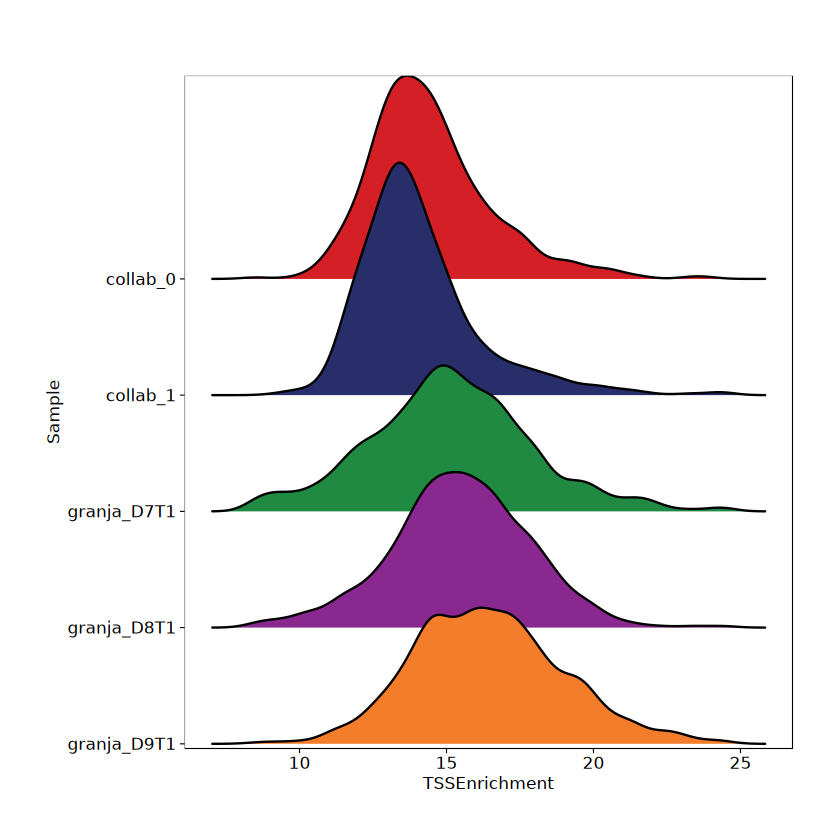

In [24]:
p1 <- plotGroups(
    ArchRProj = proj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
  plotAs = "ridges",
    baseSize = 10
)

p1

1 




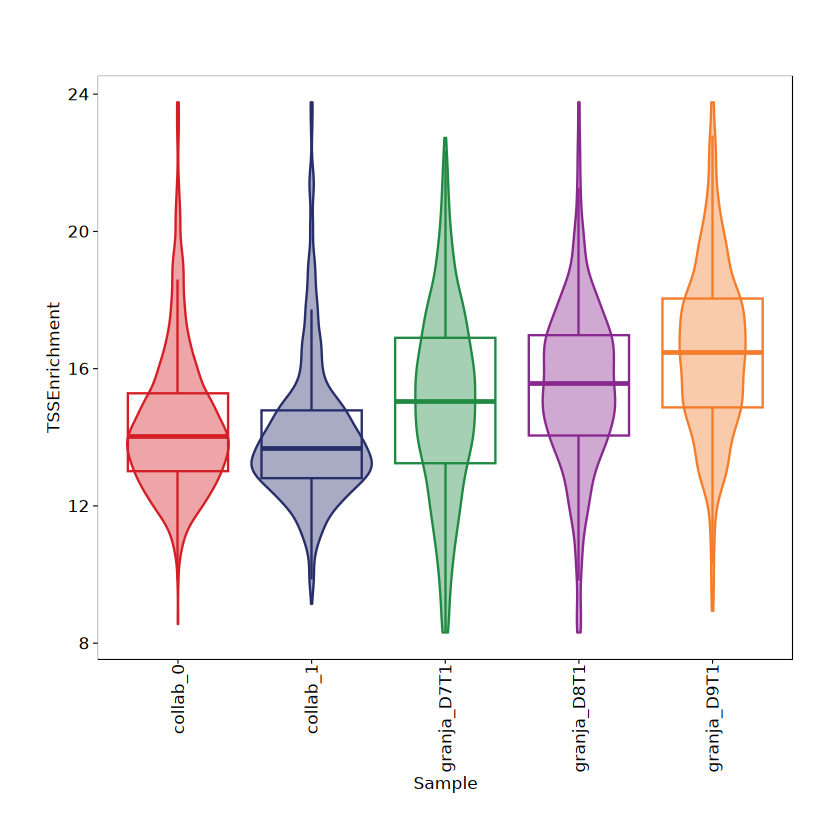

In [25]:
p2 <- plotGroups(
    ArchRProj = proj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
  name = "TSSEnrichment",
  plotAs = "violin",
  alpha = 0.4,
    baseSize = 10,
  addBoxPlot = TRUE,
)

p2

1 


Picking joint bandwidth of 0.0574



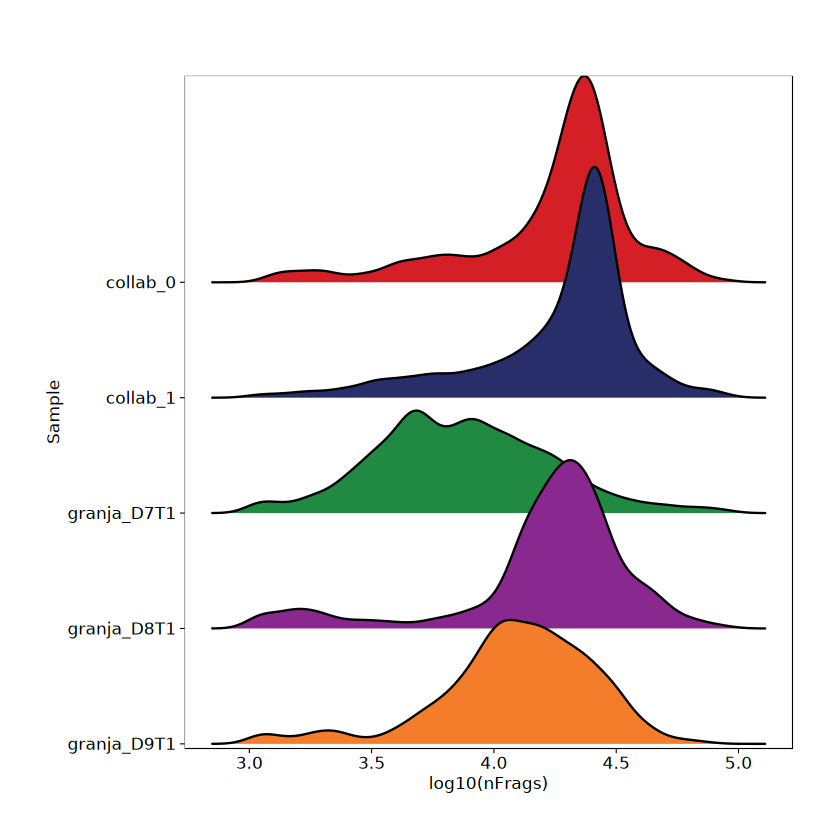

In [26]:
p3 <- plotGroups(
    ArchRProj = proj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
  name = "log10(nFrags)",
  plotAs = "ridges",
    baseSize = 10
)

p3

1 




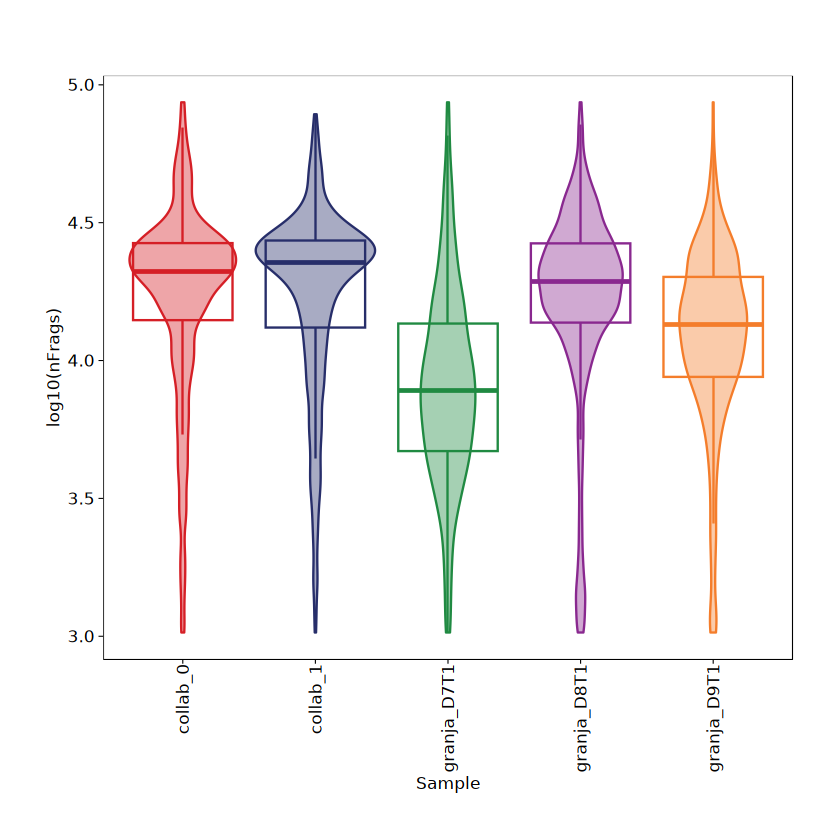

In [27]:
p4 <- plotGroups(
    ArchRProj = proj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
  name = "log10(nFrags)",
  plotAs = "violin",
    alpha = 0.4,
    baseSize = 10,
  addBoxPlot = TRUE
)

p4

1 


Picking joint bandwidth of 0.463



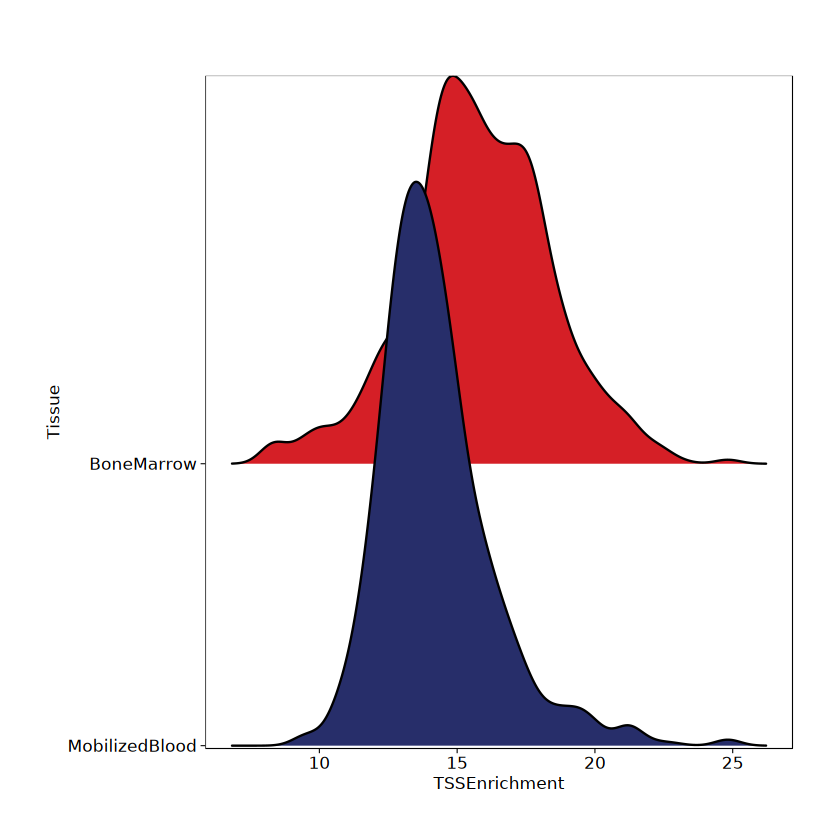

In [28]:
p5 <- plotGroups(
    ArchRProj = proj, 
    groupBy = "Tissue", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
  plotAs = "ridges",
    baseSize = 10
)


p5

1 




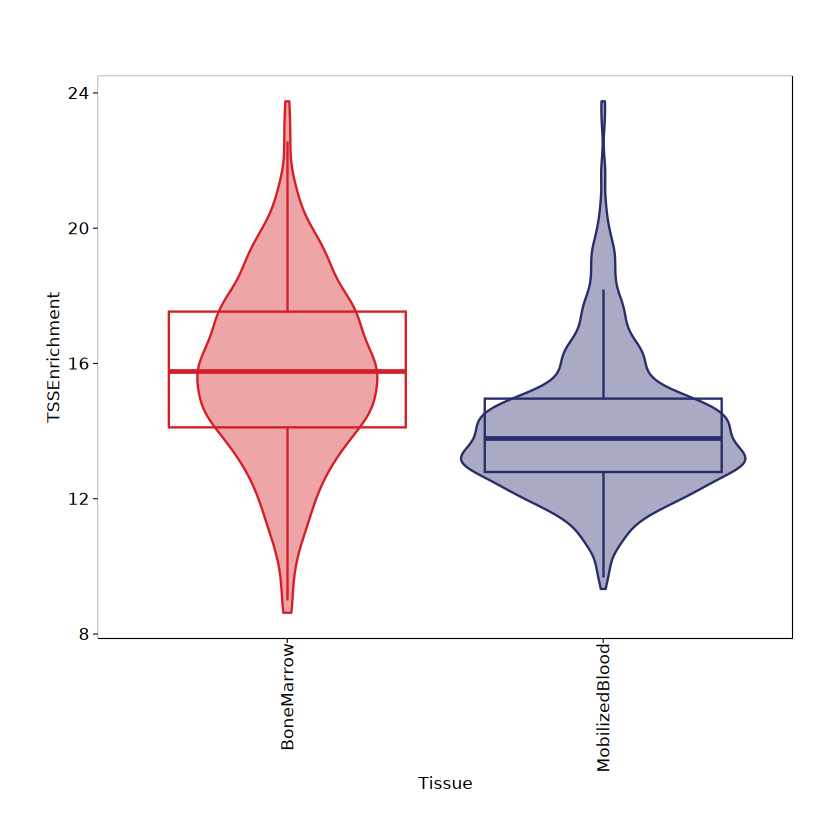

In [29]:
p6 <- plotGroups(
    ArchRProj = proj, 
    groupBy = "Tissue", 
    colorBy = "cellColData", 
  name = "TSSEnrichment",
  plotAs = "violin",
  alpha = 0.4,
    baseSize = 10,
  addBoxPlot = TRUE,
)

p6

1 


Picking joint bandwidth of 0.0652



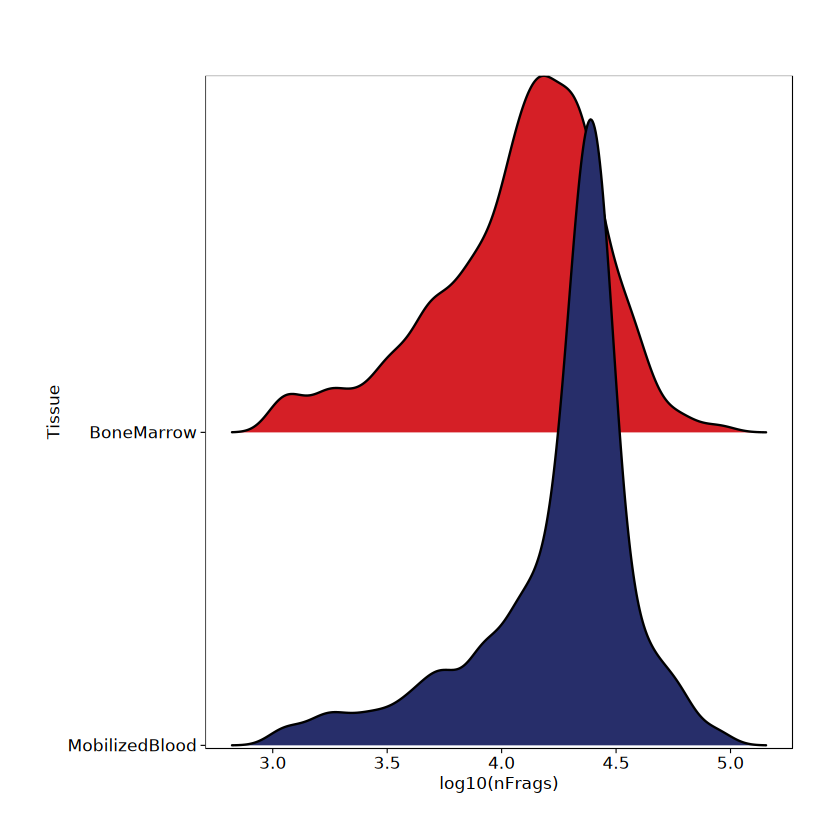

In [30]:
p7 <- plotGroups(
    ArchRProj = proj, 
    groupBy = "Tissue", 
    colorBy = "cellColData", 
  name = "log10(nFrags)",
  plotAs = "ridges",
    baseSize = 10
)

p7

1 




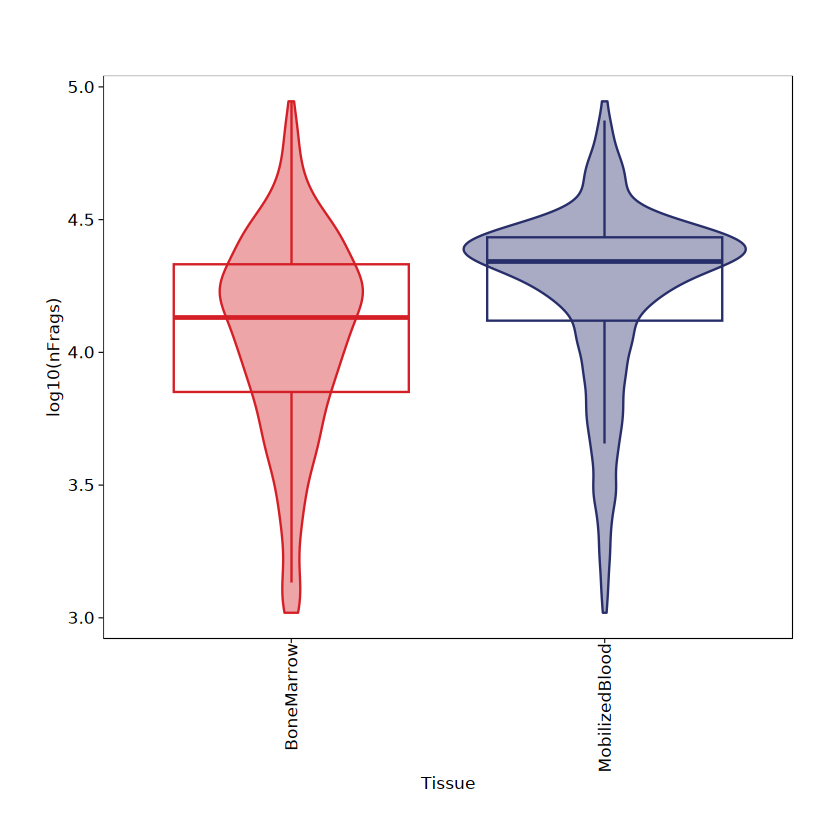

In [31]:
p8 <- plotGroups(
    ArchRProj = proj, 
    groupBy = "Tissue", 
    colorBy = "cellColData", 
  name = "log10(nFrags)",
  plotAs = "violin",
    alpha = 0.4,
    baseSize = 10,
  addBoxPlot = TRUE
)

p8

ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-dc4972d77e96-Date-2025-11-28_Time-11-08-52.809744.log
If there is an issue, please report to github with logFile!

ArchR logging successful to : ArchRLogs/ArchR-plotFragmentSizes-dc4972d77e96-Date-2025-11-28_Time-11-08-52.809744.log



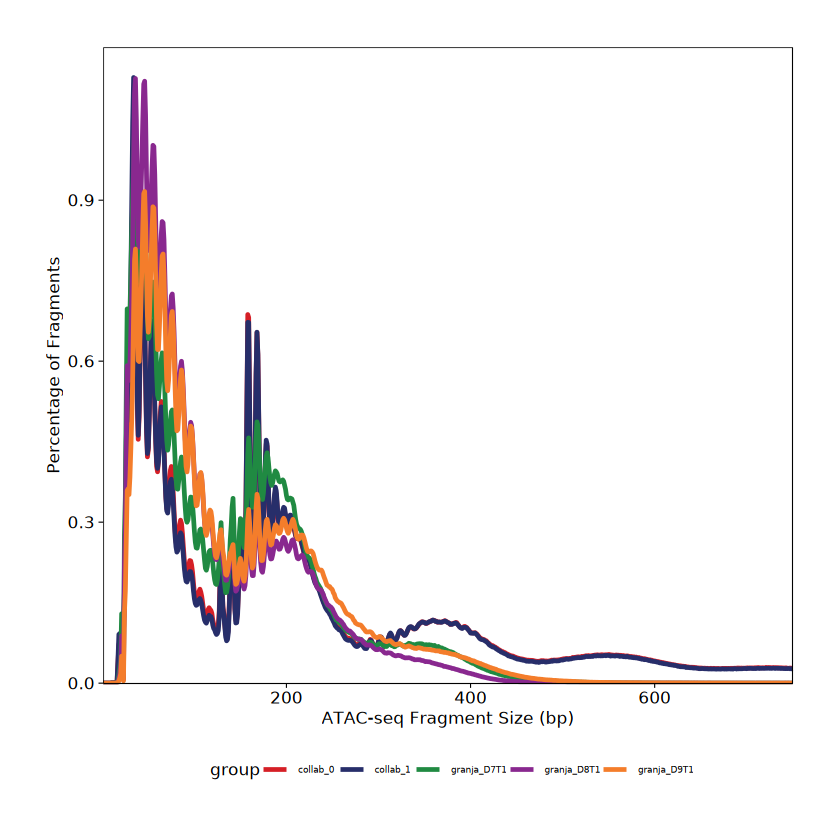

In [32]:
p1 <- plotFragmentSizes(ArchRProj = proj)
p1

ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-dc492863849a-Date-2025-11-28_Time-11-10-18.909619.log
If there is an issue, please report to github with logFile!

Disabling H5 File Locking. If this is not desired check `addArchRLocking`.

subThreading Enabled since ArchRLocking is FALSE see `addArchRLocking`

ArchR logging successful to : ArchRLogs/ArchR-plotTSSEnrichment-dc492863849a-Date-2025-11-28_Time-11-10-18.909619.log



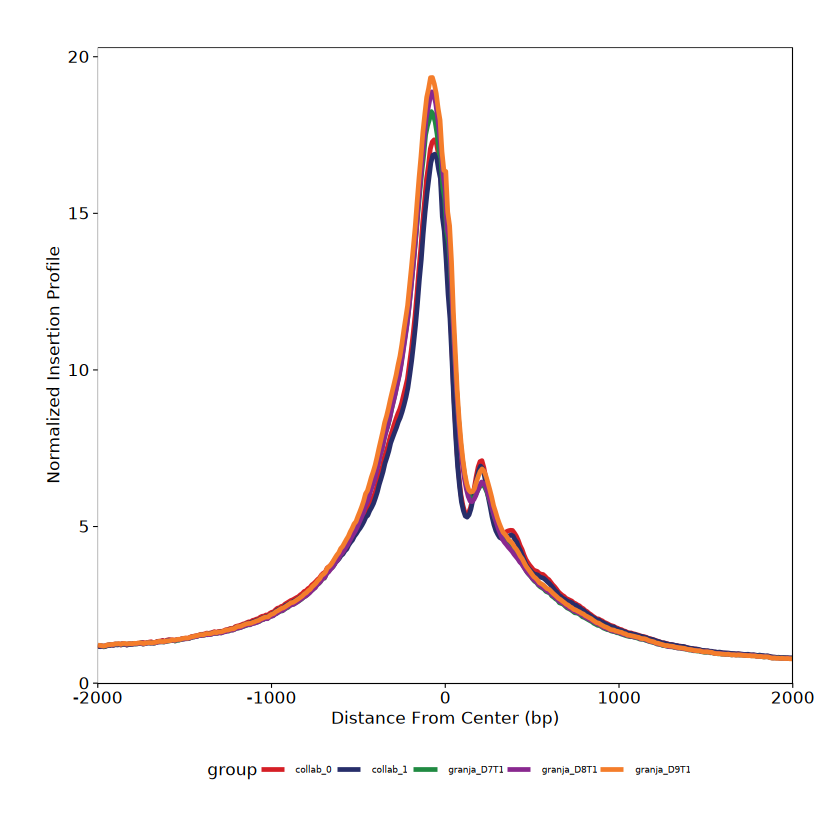

In [33]:
p2 <- plotTSSEnrichment(ArchRProj = proj)
p2

In [34]:
plotPDF(p1,p2, name = "QC-Sample-FragSizes-TSSProfile.pdf", ArchRProj = proj, addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!

Plotting Ggplot!



In [35]:
# Save
saveArchRProject(proj, load = FALSE)

Saving ArchRProject...

